# Ensemble selection for historical temperature attribution

- take SSP forcing derived in 050
- derive ensemble using constrained-correlated parameter setups (ensure same seeds are used as FaIR scenarios in 056 and 057)
- extend to SSPs 119 126 245 370 585
- remove CO2, other GHGs, other ANT one at a time

In [1]:
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as st
import random
import pandas as pd
from tqdm.notebook import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

import matplotlib.pyplot as pl
import json

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
forcing = {}
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

  0%|          | 0/10 [00:00<?, ?it/s]

## Climate model parameters

### load unconstrained

In [5]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [6]:
df_solar = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = df_solar.solar_erf.loc[1750:2019].values

df_volcanic = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((751))
volcanic_forcing[:269] = df_volcanic.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[269] = volcanic_forcing[268]

In [7]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [8]:
f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

(array([121., 574., 807., 474., 185.,  37.,  10.,  16.,  10.,   3.]),
 array([6.80758831e-04, 3.38060015e-01, 6.75439272e-01, 1.01281853e+00,
        1.35019778e+00, 1.68757704e+00, 2.02495630e+00, 2.36233555e+00,
        2.69971481e+00, 3.03709407e+00, 3.37447332e+00]),
 <a list of 10 Patch objects>)

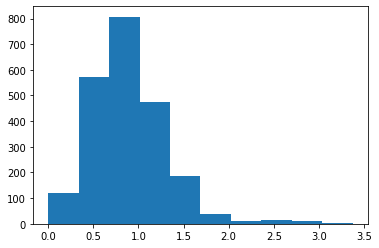

In [9]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [10]:
lamg = geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

## Forcing uncertainties and SSP projections - ensure consistency with 050

### Aerosol emissions

In [12]:
for scenario in tqdm(scenarios):
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    
    forcing[scenario]['aerosol-radiation_interactions'] = np.zeros((751, len(accept_inds)))
    forcing[scenario]['aerosol-cloud_interactions'] = np.zeros((751, len(accept_inds)))
    
    for i in tqdm(range(len(accept_inds)), leave=False):
        forcing[scenario]['aerosol-radiation_interactions'][:, i] = (
            (so2 - so2[0]) * beta_so2[i] * 32/64 +
            (bc - bc[0]) * beta_bc[i] +
            (oc - oc[0]) * beta_oc[i] +
            (nh3 - nh3[0]) * beta_nh3[i]
        )

        forcing[scenario]['aerosol-cloud_interactions'][:,i] = ghan([so2 * 32/64, bc+oc], beta[i], aci_coeffs[i,0], aci_coeffs[i,1]) - ghan([so2[0] * 32/64, bc[0]+oc[0]], beta[i], aci_coeffs[i,0], aci_coeffs[i,1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

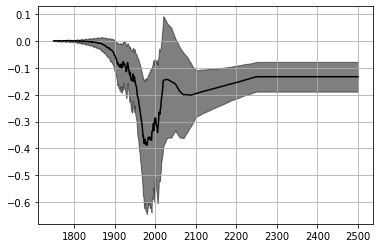

In [15]:
pl.fill_between(np.arange(1750, 2501), np.percentile(forcing[scenario]['aerosol-radiation_interactions'], 5, axis=1), np.percentile(forcing[scenario]['aerosol-radiation_interactions'], 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2501), np.percentile(forcing[scenario]['aerosol-radiation_interactions'], 50, axis=1), color='k')
pl.grid()

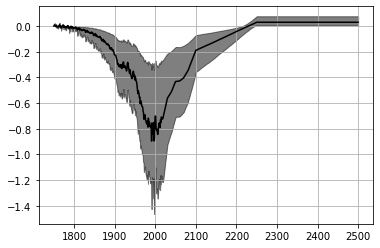

In [16]:
pl.fill_between(np.arange(1750, 2501), np.percentile(forcing[scenario]['aerosol-cloud_interactions'], 5, axis=1), np.percentile(forcing[scenario]['aerosol-cloud_interactions'], 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2501), np.percentile(forcing[scenario]['aerosol-cloud_interactions'], 50, axis=1), color='k')
pl.grid()

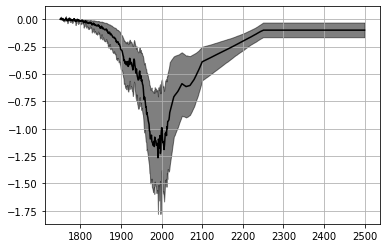

In [17]:
pl.fill_between(np.arange(1750, 2501), np.percentile(forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions'], 5, axis=1), np.percentile(forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions'], 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2501), np.percentile(forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions'], 50, axis=1), color='k')
pl.grid()

### Non-aerosol forcings and aggregated categories

In [18]:
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = np.zeros((751))
solar_forcing[:550] = df.solar_erf.loc[1750:2299].values

In [20]:
for scenario in scenarios:
    df = pd.read_csv('../data_output/SSPs/ERF_%s_1750-2500.csv' % scenario, index_col=0)
    for i, cat in enumerate(['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric', 'contrails', 'bc_on_snow', 'land_use',
               'volcanic']):
        forcing[scenario][cat] = np.zeros((751, len(accept_inds)))
        forcing[scenario][cat] = df[cat].values[:751,None] * scale_normals[:,i]
    forcing[scenario]['solar'] = np.zeros((751, len(accept_inds)))
    for j in range(len(accept_inds)):
        forcing[scenario]['solar'][:270, j] = np.linspace(0,trend_solar[j],270) + solar_forcing[:270]*scale_normals[j,10]
        forcing[scenario]['solar'][270:551, j] = trend_solar[j] + solar_forcing[270:551]*scale_normals[j,10]

In [21]:
for scenario in tqdm(scenarios):
    df = pd.read_csv('../data_output/SSPs/ERF_%s_minorGHGs_1750-2500.csv' % scenario, index_col=0)
    for i, cat in tqdm(enumerate(list(ghg_to_rcmip_names.keys())), total=len(ghg_to_rcmip_names.keys()), leave=False):
        forcing[scenario][cat] = np.zeros((351, len(accept_inds)))
        forcing[scenario][cat] = df[cat].values[:351,None] * scale_normals[:,3]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [24]:
for scenario in scenarios:
    forcing[scenario]['total'] = (
        forcing[scenario]['co2'] +
        forcing[scenario]['ch4'] +
        forcing[scenario]['n2o'] +
        forcing[scenario]['other_wmghg'] +
        forcing[scenario]['o3'] +
        forcing[scenario]['h2o_stratospheric'] +
        forcing[scenario]['contrails'] +
        forcing[scenario]['aerosol-radiation_interactions'] +
        forcing[scenario]['aerosol-cloud_interactions'] +
        forcing[scenario]['bc_on_snow'] +
        forcing[scenario]['land_use'] +
        forcing[scenario]['solar'] +
        forcing[scenario]['volcanic']
    )

In [25]:
forcing[scenario]['total'][:,0].shape

(751,)

# Run climate model

In [26]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)

In [27]:
cmix_mean = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep_mean = cmip6_models['cdeep']['mean']['EBM-epsilon']
eff_mean = cmip6_models['eff']['mean']['EBM-epsilon']

lamg_median = f2x_median/ecs_median
kappa_median = -(f2x_median/ecs_median - f2x_median/tcr_median)
gamma_2l_median = kappa_median/eff_mean

In [28]:
gamma_2l_median, kappa_median, lamg_median, eff_mean

(0.6395952745483992, 0.85785768256684, 1.3670409092103908, 1.3412508139190835)

In [29]:
results_ch9 = {}
mkdir_p('../data_output_large/chapter9/')

## 751-year forcing runs

- all anthropogenic forcing
- include climate variability

In [31]:
for scenario in tqdm(scenarios, desc='scenario'):
    arglist = []

    lamg = -geoff_sample_df['lamg'].values
    eff = geoff_sample_df['eff'].values
    gamma_2l = geoff_sample_df['gamma_2l'].values
    cdeep = geoff_sample_df['cdeep'].values
    cmix = geoff_sample_df['cmix'].values


    for i in range(len(accept_inds)):
        arglist.append(
            {
                'cmix': cmix[i],
                'cdeep': cdeep[i],
                'gamma_2l': gamma_2l[i],
                'lamg': lamg[i],
                'eff': eff[i],
                'in_forcing' : forcing[scenario]['anthro'][:,i],
            }
        )

    results_ch9[scenario] = {}

    def run_tlm(args):
        in_forcing = args['in_forcing']
        driver = TwoLayerModel(
            extforce=in_forcing,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=args['lamg'],
            t2x=None,
            eff=args['eff'],
            cmix=args['cmix'],
            cdeep=args['cdeep'],
            gamma_2l=args['gamma_2l'],
            outtime=np.arange(1750,2501),
            dt=0.2
        )
        output = driver.run()
        return(
            output.tg,
            output.tlev[:,1],
            output.hflux,
            output.ohc
        )


    if __name__ == '__main__':
        with Pool(24) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = np.array(result)
        
    output_t = output.transpose(1,2,0)

    results_ch9[scenario]['effective_radiative_forcing'] = forcing[scenario]['anthro']
    results_ch9[scenario]['surface_temperature'] = output_t[0,...]
    results_ch9[scenario]['deep_ocean_temperature'] = output_t[1,...]
    results_ch9[scenario]['net_energy_imbalance'] = output_t[2,...]
    results_ch9[scenario]['ocean_heat_content'] = output_t[3,...] * 1e22
    results_ch9[scenario]['ECS'] = ecs
    results_ch9[scenario]['TCR'] = tcr
    results_ch9[scenario]['lambda0'] = lamg
    results_ch9[scenario]['cmix'] = cmix
    results_ch9[scenario]['cdeep'] = cdeep
    results_ch9[scenario]['efficacy'] = eff
    results_ch9[scenario]['eta'] = gamma_2l
results_ch9['year'] = np.arange(1750, 2501)

scenario:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

In [32]:
save_dict_to_hdf5(results_ch9, '../data_output_large/chapter9/twolayer_SSPs.h5')